### 📄문서 변환 및 설정
#### Docling을 사용한 PDF 문서 변환
팔란티어 10-K 보고서 PDF를 마크다운 형식으로 변환합니다. 변환 과정을 모니터링하기 위해 로깅을 설정하고 처리 시간을 측정합니다.


In [1]:
import logging
import time
from pathlib import Path
from docling.document_converter import DocumentConverter

# 로깅 설정 - INFO 레벨로 변환 과정을 모니터링
logging.basicConfig(level=logging.INFO)
_log = logging.getLogger(__name__)

# 입력 PDF 파일 경로와 출력 디렉토리 설정
input_doc_path = Path("./data/2024 FY PLTR 10-K.pdf")
output_dir = Path("./data/palantir_10k/output")

doc_converter = DocumentConverter()

# 변환 시작 시간 기록
start_time = time.time()

# PDF 문서 변환 실행
conv_res = doc_converter.convert(input_doc_path)

INFO:docling.document_converter:Going to convert document batch...
INFO:docling.document_converter:Initializing pipeline for StandardPdfPipeline with options hash 70041f74270850b7bedf7c8f5c2dcede
INFO:docling.models.factories.base_factory:Loading plugin 'docling_defaults'
INFO:docling.models.factories:Registered ocr engines: ['easyocr', 'ocrmac', 'rapidocr', 'tesserocr', 'tesseract']
INFO:docling.utils.accelerator_utils:Accelerator device: 'cuda:0'
INFO:docling.utils.accelerator_utils:Accelerator device: 'cuda:0'
INFO:docling.utils.accelerator_utils:Accelerator device: 'cuda:0'
INFO:docling.models.factories.base_factory:Loading plugin 'docling_defaults'
INFO:docling.models.factories:Registered picture descriptions: ['vlm', 'api']
INFO:docling.pipeline.base_pipeline:Processing document 2024 FY PLTR 10-K.pdf
c:\Users\user\anaconda3\envs\test_venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Us

### ✂️ 문서 분할 및 청킹
#### 텍스트 분할기를 사용한 문서 청킹
변환된 마크다운 문서를 검색에 적합한 크기의 청크로 분할합니다. 헤더 구분자를 우선으로 하여 문서 구조를 유지하면서 분할합니다.


In [2]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document

document = conv_res.document.export_to_markdown()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=3000,
    chunk_overlap=500,
    separators=["##\n","\n\n", "\n", " ", ""]
)

# 메타데이터 설정
metadata = {
    "source": str(input_doc_path),
    "filename": input_doc_path.name,
    "file_type": "pdf"
}

splits = text_splitter.create_documents([document], metadatas=[metadata])

 
### 🔍 첫 번째 청크 확인
분할된 문서의 첫 번째 청크 내용을 확인하여 분할이 제대로 되었는지 검증합니다.


In [3]:
splits[0]

Document(metadata={'source': 'data\\2024 FY PLTR 10-K.pdf', 'filename': '2024 FY PLTR 10-K.pdf', 'file_type': 'pdf'}, page_content="## UNITED STATES SECURITIES AND EXCHANGE COMMISSION WASHINGTON, DC 20549 FORM 10-K\n\n(Mark One)\n\n☒ ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934\n\nFor the fiscal year ended December 31, 2024 OR\n\n☐ TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934\n\nFor the transition period from\n\n\\_\\_\\_\\_\\_\\_\\_\\_\\_\n\nto\n\n\\_\\_\\_\\_\\_\\_\\_\\_\\_\n\nCommission File Number: 001-39540\n\n## Palantir Technologies Inc.\n\n(Exact Name of Registrant as Specified in its Charter)\n\n\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\n\nDelaware\n\n68-0551851\n\n(State or other jurisdiction of incorporation or organization)\n\n(I.R.S. Employer Identification No.)\n\n1200 17th Street, Floor 

 
### 📊 청크 분포 분석
#### 분할된 청크들의 통계 정보
총 청크 수와 각 청크의 길이 분포를 분석하여 분할 품질을 평가합니다.


In [4]:
# splits 길이 분포 파악
split_lengths = [len(split.page_content) for split in splits]
print(f"총 분할된 청크 수: {len(splits)}")
print(f"평균 청크 길이: {sum(split_lengths) / len(split_lengths):.1f} 문자")
print(f"최소 청크 길이: {min(split_lengths)} 문자")
print(f"최대 청크 길이: {max(split_lengths)} 문자")

총 분할된 청크 수: 341
평균 청크 길이: 2389.3 문자
최소 청크 길이: 198 문자
최대 청크 길이: 2998 문자


### 🏗️ 벡터 스토어 구축
#### Qdrant 하이브리드 검색 시스템 설정
Ollama BGE-M3 임베딩과 FastEmbed BM25를 조합한 하이브리드 검색 시스템을 구축합니다. 밀집 벡터와 희소 벡터를 모두 활용하여 검색 성능을 향상시킵니다.


In [5]:
from langchain_ollama import OllamaEmbeddings
from langchain_qdrant import FastEmbedSparse, QdrantVectorStore, RetrievalMode
from qdrant_client import QdrantClient, models
from qdrant_client.http.models import Distance, SparseVectorParams, VectorParams

# Qdrant 클라이언트 설정
client = QdrantClient(host="localhost", port=6333)

dense_embeddings = OllamaEmbeddings(model="bge-m3")
sparse_embeddings = FastEmbedSparse(model_name="Qdrant/bm25")

# 컬렉션 이름 설정
collection_name = f"finance_rag"
try:
    client.create_collection(
        collection_name=collection_name,
        vectors_config={"dense": VectorParams(size=1024, distance=Distance.COSINE)},
        sparse_vectors_config={
            "sparse": SparseVectorParams(index=models.SparseIndexParams(on_disk=False))
        },
    )
    print(f"새 컬렉션 '{collection_name}' 생성됨")
    qdrant = QdrantVectorStore(
        client=client,
        collection_name=collection_name,
        embedding=dense_embeddings,
        sparse_embedding=sparse_embeddings,
        retrieval_mode=RetrievalMode.HYBRID,
        vector_name="dense",
        sparse_vector_name="sparse",
    )

    # 문서를 벡터 스토어에 추가
    print("문서를 벡터 스토어에 추가 중...")
    qdrant.add_documents(splits)
    print(f"✅ {len(splits)}개의 문서가 Qdrant에 저장되었습니다.")
    
except:
    qdrant = QdrantVectorStore(
        client=client,
        collection_name=collection_name,
        embedding=dense_embeddings,
        sparse_embedding=sparse_embeddings,
        retrieval_mode=RetrievalMode.HYBRID,
        vector_name="dense",
        sparse_vector_name="sparse",
    )

INFO:httpx:HTTP Request: PUT http://localhost:6333/collections/finance_rag "HTTP/1.1 409 Conflict"
INFO:httpx:HTTP Request: GET http://localhost:6333/collections/finance_rag "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/embed "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET http://localhost:6333/collections/finance_rag "HTTP/1.1 200 OK"


### 📈테이블 데이터 추출 및 저장
#### 문서 내 테이블을 CSV 파일로 저장
10-K 보고서에 포함된 모든 테이블을 DataFrame으로 변환하고 CSV 파일로 저장합니다. 구조화된 재무 데이터를 별도로 관리하여 정확한 수치 분석을 지원합니다.


In [6]:
import pandas as pd
# Export tables
for table_ix, table in enumerate(conv_res.document.tables):
    table_df: pd.DataFrame = table.export_to_dataframe()
    print(f"## Table {table_ix}")
    print(table_df.to_markdown())

## Table 0
|    |                 |                                                                                                                                                                                                                                                                                          | Page   |
|---:|:----------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-------|
|  0 | PART            | I                                                                                                                                                                                                                                                                                        |        |
|  1 | Item 1.         | Business ....

In [7]:
import pandas as pd
import time


output_dir.mkdir(parents=True, exist_ok=True)

doc_filename = conv_res.input.file.stem

# Export tables
for table_ix, table in enumerate(conv_res.document.tables):
    table_df: pd.DataFrame = table.export_to_dataframe()
    print(f"## Table {table_ix}")
    print(table_df.to_markdown())

    # Save the table as csv
    element_csv_filename = output_dir / f"{doc_filename}-table-{table_ix + 1}.csv"
    _log.info(f"Saving CSV table to {element_csv_filename}")
    table_df.to_csv(element_csv_filename)

end_time = time.time() - start_time

_log.info(f"Document converted and tables exported in {end_time:.2f} seconds.")

INFO:__main__:Saving CSV table to data\palantir_10k\output\2024 FY PLTR 10-K-table-1.csv
INFO:__main__:Saving CSV table to data\palantir_10k\output\2024 FY PLTR 10-K-table-2.csv
INFO:__main__:Saving CSV table to data\palantir_10k\output\2024 FY PLTR 10-K-table-3.csv
INFO:__main__:Saving CSV table to data\palantir_10k\output\2024 FY PLTR 10-K-table-4.csv
INFO:__main__:Saving CSV table to data\palantir_10k\output\2024 FY PLTR 10-K-table-5.csv
INFO:__main__:Saving CSV table to data\palantir_10k\output\2024 FY PLTR 10-K-table-6.csv
INFO:__main__:Saving CSV table to data\palantir_10k\output\2024 FY PLTR 10-K-table-7.csv
INFO:__main__:Saving CSV table to data\palantir_10k\output\2024 FY PLTR 10-K-table-8.csv
INFO:__main__:Saving CSV table to data\palantir_10k\output\2024 FY PLTR 10-K-table-9.csv
INFO:__main__:Saving CSV table to data\palantir_10k\output\2024 FY PLTR 10-K-table-10.csv
INFO:__main__:Saving CSV table to data\palantir_10k\output\2024 FY PLTR 10-K-table-11.csv
INFO:__main__:Savin

## Table 0
|    |                 |                                                                                                                                                                                                                                                                                          | Page   |
|---:|:----------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-------|
|  0 | PART            | I                                                                                                                                                                                                                                                                                        |        |
|  1 | Item 1.         | Business ....

INFO:__main__:Saving CSV table to data\palantir_10k\output\2024 FY PLTR 10-K-table-43.csv
INFO:__main__:Saving CSV table to data\palantir_10k\output\2024 FY PLTR 10-K-table-44.csv
INFO:__main__:Saving CSV table to data\palantir_10k\output\2024 FY PLTR 10-K-table-45.csv
INFO:__main__:Saving CSV table to data\palantir_10k\output\2024 FY PLTR 10-K-table-46.csv
INFO:__main__:Saving CSV table to data\palantir_10k\output\2024 FY PLTR 10-K-table-47.csv
INFO:__main__:Saving CSV table to data\palantir_10k\output\2024 FY PLTR 10-K-table-48.csv
INFO:__main__:Saving CSV table to data\palantir_10k\output\2024 FY PLTR 10-K-table-49.csv
INFO:__main__:Saving CSV table to data\palantir_10k\output\2024 FY PLTR 10-K-table-50.csv
INFO:__main__:Saving CSV table to data\palantir_10k\output\2024 FY PLTR 10-K-table-51.csv
INFO:__main__:Saving CSV table to data\palantir_10k\output\2024 FY PLTR 10-K-table-52.csv
INFO:__main__:Saving CSV table to data\palantir_10k\output\2024 FY PLTR 10-K-table-53.csv
INFO:__mai

## Table 42
|    |                                  | Years Ended December 31,.2024   | Years Ended December 31,.2023   | Years Ended December 31,.2022   |
|---:|:---------------------------------|:--------------------------------|:--------------------------------|:--------------------------------|
|  0 | Current:                         |                                 |                                 |                                 |
|  1 | Federal                          | $ -                             | $ -                             | $ -                             |
|  2 | State                            | 1,556                           | 2,333                           | 765                             |
|  3 | Foreign                          | 20,265                          | 22,189                          | 9,476                           |
|  4 | Total current provision          | 21,821                          | 24,522                          | 10,241        

### 📋 CSV 파일 요약 분석
#### 추출된 테이블 데이터 구조 파악
저장된 CSV 파일들의 컬럼 구조와 샘플 데이터를 요약하여 각 테이블의 내용을 파악합니다. 이후 RAG 시스템에서 적절한 테이블을 선택하는 데 활용됩니다.


In [8]:
import pandas as pd
from pathlib import Path

def summarize_csv(path: Path, n_rows: int = 3) -> str:
    df = pd.read_csv(path)
    cols = df.columns.tolist()
    sample = df.head(n_rows).to_dict(orient="records")
    # 컬럼 리스트와 첫 3개 행 요약
    return f"Columns: {cols}\nSample: {sample}"

# 예시: output_dir 안 모든 CSV에 대해 요약 생성
csv_dir = Path("./data/palantir_10k/output")
summaries = {}
for csv_path in csv_dir.glob("*.csv"):
    summaries[csv_path.stem] = summarize_csv(csv_path)

# summaries 예시 출력
for name, summ in summaries.items():
    print(f"{name}:\n{summ}\n")

2024 FY PLTR 10-K-table-1:
Columns: ['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Page']
Sample: [{'Unnamed: 0': 0, 'Unnamed: 1': 'PART', 'Unnamed: 2': 'I', 'Page': nan}, {'Unnamed: 0': 1, 'Unnamed: 1': 'Item 1.', 'Unnamed: 2': 'Business ..............................................................................................................................................................', 'Page': 4.0}, {'Unnamed: 0': 2, 'Unnamed: 1': 'Item 1A.', 'Unnamed: 2': 'Risk Factors.........................................................................................................................................................', 'Page': 12.0}]

2024 FY PLTR 10-K-table-10:
Columns: ['Unnamed: 0', 'Unnamed: 1', 'Years Ended December 31,.2024', 'Years Ended December 31,.2023', 'Change.Amount', 'Change.%']
Sample: [{'Unnamed: 0': 0, 'Unnamed: 1': 'Sales and marketing', 'Years Ended December 31,.2024': '$ 887,755', 'Years Ended December 31,.2023': '$ 744,992', 'Change.Amount': '$ 142,763',

### 🔧 환경 변수 로드
API 키 등 환경 설정을 로드합니다.


In [9]:
from dotenv import load_dotenv

load_dotenv()

True

### 🔍 멀티쿼리 생성기 구현
#### 검색 성능 향상을 위한 쿼리 다양화
사용자의 단일 질문을 여러 관점의 질문으로 확장하여 검색 결과의 다양성과 포괄성을 높입니다. 거리 기반 유사도 검색의 한계를 극복하는 핵심 기법입니다.


In [10]:
from langchain_ollama import ChatOllama
from langchain_core.prompts import PromptTemplate
from langchain.retrievers.multi_query import LineListOutputParser
from typing import List

gemma=ChatOllama(model="gemma3:4b")

def create_multiquery_generator(llm, num_queries=3):
    """멀티쿼리 생성기 생성"""
    
    # Output parser 초기화
    output_parser = LineListOutputParser()
    
    # 멀티쿼리 생성 프롬프트
    QUERY_PROMPT = PromptTemplate(
        input_variables=["question", "num_queries"],
        template="""당신은 AI 어시스턴트입니다. 사용자의 질문을 다양한 관점에서 재구성하여 
                    더 포괄적인 검색이 가능하도록 도와주세요. 거리 기반 유사도 검색의 한계를 극복하기 위해 
                    원본 질문에 대한 다양한 관점의 질문들을 {num_queries}개 생성해주세요.

                    각 질문은 줄바꿈으로 구분하여 제공해주세요.
                    원본 질문: {question}
                    {num_queries}개의 질문:
                    (print from here)
                    """
    )
    
    # 멀티쿼리 생성 체인 생성 (이것이 Runnable입니다)
    multiquery_chain = QUERY_PROMPT | llm | output_parser
    
    print(f"🔍 멀티쿼리 생성기 설정 완료 (질문 수: {num_queries}개)")
    return multiquery_chain

### 🧪 멀티쿼리 생성 테스트
생성된 멀티쿼리 기능을 테스트하여 정상 작동하는지 확인합니다.


In [11]:
# 멀티쿼리 생성기 생성
multiquery_generator = create_multiquery_generator(gemma, 5)
multiquery_generator.invoke({"question": "팔란티어의 재무 상태", "num_queries": 5})

🔍 멀티쿼리 생성기 설정 완료 (질문 수: 5개)


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


['팔란티어의 재무 건전성 및 위험 요소는 무엇인가?',
 '팔란티어의 자산, 부채, 수익성, 현금 흐름은 어떠한가?',
 '팔란티어의 재무제표 분석 결과, 특히 주목해야 할 사항은 무엇인가?',
 '팔란티어의 재무 상태가 경쟁사들과 비교했을 때 어떤 강점과 약점을 가지고 있는가?',
 '팔란티어의 재무 상태가 향후 성장 가능성에 어떤 영향을 미칠 수 있는가?']

### 🚀 LangGraph 기반 에이전틱 RAG 시스템 구축
#### 지능형 라우팅 및 다중 분석 파이프라인
질문 유형에 따라 CSV 데이터 분석 또는 문서 검색을 자동으로 선택하는 에이전틱 RAG 시스템을 구현합니다. 각 단계별 노드와 라우팅 로직을 정의합니다.


In [15]:
from langgraph.graph import StateGraph, END
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from langchain_openai import ChatOpenAI
from typing import TypedDict, List
import pandas as pd
from pydantic import BaseModel
from typing import Literal

llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)
retriever = qdrant.as_retriever(k=5)

# State 정의
class GraphState(TypedDict):
    question: str
    analysis_type: str  # "csv" or "document"
    selected_csv: str
    retrieved_docs: List[str]
    answer: str

# 1) 질의 분석 및 라우팅 노드
def analyze_query_node(state: GraphState) -> GraphState:
    question = state["question"]
    
    routing_prompt = f"""
    다음 질문을 분석하여 어떤 유형의 분석이 필요한지 판단해주세요:
    
    질문: {question}
    
    판단 기준:
    - CSV 분석이 필요한 경우: 구체적인 재무 데이터 분석, 수치 계산, 차트 생성, 통계 분석 등이 필요한 질문
    - 문서 검색이 필요한 경우: 일반적인 정보 조회, 개념 설명, 정성적 분석 등이 필요한 질문
    
    "csv" 또는 "document" 중 하나만 답해주세요:
    """
    class Routing(BaseModel):
        query_type: Literal["csv", "document"]

    llm_with_structured_output=llm.with_structured_output(Routing)

    response = llm_with_structured_output.invoke(routing_prompt)
    analysis_type = response.query_type
    
    return {
        "question": question,
        "analysis_type": analysis_type,
        "selected_csv": "",
        "retrieved_docs": [],
        "answer": ""
    }

# 2) CSV 라우팅 노드
def route_csv_node(state: GraphState) -> GraphState:
    question = state["question"]
        
    # CSV 옵션들과 설명을 준비
    csv_options = []
    for csv_path in csv_dir.glob("*.csv"):
        csv_name = csv_path.stem
        csv_summary = summarize_csv(csv_path)
        csv_options.append(f"- {csv_name}: {csv_summary}")
    
    options_text = "\n".join(csv_options)
    
    routing_prompt = f"""
    질문: {question}
    
    사용 가능한 CSV 파일들:
    {options_text}
    
    위 질문에 답하기 위해 가장 적합한 CSV 파일의 이름만 답해주세요 (확장자 제외):
    """
    
    response = llm.invoke(routing_prompt)
    selected_csv = response.content.strip()
    
    return {
        "question": state["question"],
        "analysis_type": state["analysis_type"],
        "selected_csv": selected_csv,
        "retrieved_docs": state["retrieved_docs"],
        "answer": ""
    }

# 3) Pandas Agent 실행 노드
def pandas_agent_node(state: GraphState) -> GraphState:
    question = state["question"]
    selected_csv = state["selected_csv"]
    
    # 선택된 CSV 파일 로드
    csv_path = csv_dir / f"{selected_csv}.csv"
    
    if not csv_path.exists():
        return {
            "question": question,
            "analysis_type": state["analysis_type"],
            "selected_csv": selected_csv,
            "retrieved_docs": state["retrieved_docs"],
            "answer": f"Error: CSV file {selected_csv}.csv not found"
        }
    
    df = pd.read_csv(csv_path)
    
    # Pandas DataFrame Agent 생성 - iteration limit 증가 및 timeout 설정
    agent = create_pandas_dataframe_agent(
        llm,
        df,
        verbose=True,
        return_intermediate_steps=True,
        allow_dangerous_code=True,
        max_iterations=20,  # iteration limit 증가
        max_execution_time=60,  # 60초 timeout 설정
        early_stopping_method="generate"  # 조기 종료 방법 설정
    )
    
    # 질문 실행
    try:
        response = agent.invoke({"input": question})
        answer = str(response["output"])
    except Exception as e:
        answer = f"Error executing pandas agent: {e}"
    
    return {
        "question": question,
        "analysis_type": state["analysis_type"],
        "selected_csv": selected_csv,
        "retrieved_docs": state["retrieved_docs"],
        "answer": answer
    }

# 4) 문서 검색 노드
def document_retrieval_node(state: GraphState) -> GraphState:
    question = state["question"]
    
    try:
        # 멀티쿼리 생성
        multi_queries = multiquery_generator.invoke({"question": question, "num_queries": 5})
        
        # 각 쿼리로 검색 수행
        all_docs = []
        for query in multi_queries:
            docs = retriever.invoke(query)
            all_docs.extend([doc.page_content for doc in docs])
        
        # 중복 제거
        unique_docs = list(set(all_docs))
        
        # 검색된 문서를 바탕으로 답변 생성
        context = "\n\n".join(unique_docs[:5])  # 상위 5개 문서만 사용
        
        answer_prompt = f"""
        다음 문서들을 참고하여 질문에 답해주세요:
        
        질문: {question}
        
        참고 문서:
        {context}
        
        답변:
        """
        
        response = llm.invoke(answer_prompt)
        answer = response.content
        
    except Exception as e:
        unique_docs = []
        answer = f"Error during document retrieval: {e}"
    
    return {
        "question": question,
        "analysis_type": state["analysis_type"],
        "selected_csv": state["selected_csv"],
        "retrieved_docs": unique_docs,
        "answer": answer
    }

# 5) 라우팅 조건 함수
def route_analysis_type(state: GraphState) -> str:
    analysis_type = state["analysis_type"]
    if analysis_type == "csv":
        return "csv_routing"
    else:
        return "document_retrieval"

# 6) LangGraph 구축
def create_finance_rag_graph():
    workflow = StateGraph(GraphState)
    
    # 노드 추가
    workflow.add_node("analyze_query", analyze_query_node)
    workflow.add_node("csv_routing", route_csv_node)
    workflow.add_node("pandas_agent", pandas_agent_node)
    workflow.add_node("document_retrieval", document_retrieval_node)
    
    # 엣지 추가
    workflow.set_entry_point("analyze_query")
    
    # 조건부 엣지 추가
    workflow.add_conditional_edges(
        "analyze_query",
        route_analysis_type,
        {
            "csv_routing": "csv_routing",
            "document_retrieval": "document_retrieval"
        }
    )
    
    workflow.add_edge("csv_routing", "pandas_agent")
    workflow.add_edge("pandas_agent", END)
    workflow.add_edge("document_retrieval", END)
    
    return workflow.compile()

# 7) 그래프 실행
app = create_finance_rag_graph()

### 📊 워크플로우 시각화
#### LangGraph 실행 흐름 다이어그램
구축된 에이전틱 RAG 시스템의 실행 흐름을 시각적으로 확인합니다.


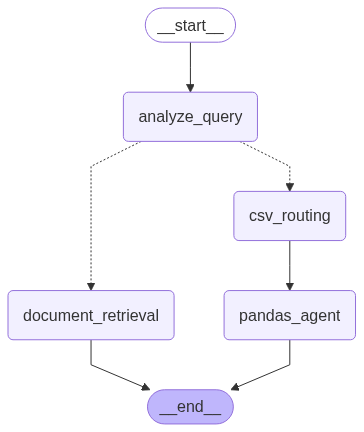

In [16]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

### 💬 실제 질문으로 시스템 테스트
#### 통합 RAG 시스템 실행 및 결과 분석
팔란티어의 비즈니스 모델과 성장 전략에 대한 복합적인 질문으로 시스템을 테스트합니다. 각 처리 단계별 정보를 스트리밍으로 출력하여 실행 과정을 모니터링합니다.


In [21]:
# 질문 실행 (스트리밍)
initial_state = {
    "question": "팔란티어의 매출 추이에 대해서 정량적으로 분석해주세요.",
    "selected_csv": "",
    "answer": ""
}

print("🚀 Finance RAG 분석을 시작합니다...\n")

# 스트리밍으로 각 단계별 정보 출력
for step in app.stream(initial_state):
    node_name = list(step.keys())[0]
    node_output = step[node_name]
    
    print(f"📍 현재 단계: {node_name}")
    
    if node_name == "analyze_query":
        print(f"   🔍 분석 타입: {node_output.get('analysis_type', 'N/A')}")
        print(f"   📝 질문: {node_output.get('question', 'N/A')}")
    
    elif node_name == "csv_routing":
        print(f"   📊 선택된 CSV: {node_output.get('selected_csv', 'N/A')}")
    
    elif node_name == "pandas_agent":
        print(f"   🤖 Pandas Agent 분석 완료")
        if node_output.get('answer'):
            print(f"   💡 답변 길이: {len(node_output['answer'])} 문자")
    
    elif node_name == "document_retrieval":
        print(f"   📚 문서 검색 완료")
        if node_output.get('answer'):
            print(f"   💡 답변 길이: {len(node_output['answer'])} 문자")
    
    print("   " + "="*50)
    print()

# 최종 결과 출력
final_result = node_output
print("✅ 분석 완료!")
print(f"📊 최종 선택된 CSV: {final_result.get('selected_csv', 'N/A')}")
print(f"📝 최종 답변 미리보기: {final_result.get('answer', 'N/A')[:100]}...")

🚀 Finance RAG 분석을 시작합니다...



INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


📍 현재 단계: analyze_query
   🔍 분석 타입: csv
   📝 질문: 팔란티어의 매출 추이에 대해서 정량적으로 분석해주세요.



INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


📍 현재 단계: csv_routing
   📊 선택된 CSV: 2024 FY PLTR 10-K-table-6



> Entering new AgentExecutor chain...


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Thought: The question asks for a quantitative analysis of Palantir's revenue trend. The revenue data is in the row where the second column is "Revenue" and the revenue values are in the columns for the years 2024, 2023, and 2022. I need to extract these revenue values, convert them to numeric format, and then analyze the trend over the three years.

Action: I will extract the revenue row and convert the revenue values to numeric.

Action Input: 
```python
# Extract the revenue row
revenue_row = df[df['Unnamed: 1'] == 'Revenue']

# Extract revenue values for the years 2024, 2023, 2022
revenue_2024 = revenue_row['Years Ended December 31,.2024'].values[0]
revenue_2023 = revenue_row['Years Ended December 31,.2023'].values[0]
revenue_2022 = revenue_row['Years Ended December 31,.2022'].values[0]

# Remove $ and commas, convert to int
revenue_2024 = int(revenue_2024.replace('$', '').replace(',', '').strip())
revenue_2023 = int(revenue_2023.replace('$', '').replace(',', '').strip())
revenue_20

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Thought: I need to run the Python code to extract and convert the revenue values from the dataframe.

Action: python_repl_ast
Action Input: 
```python
# Extract the revenue row
revenue_row = df[df['Unnamed: 1'] == 'Revenue']

# Extract revenue values for the years 2024, 2023, 2022
revenue_2024 = revenue_row['Years Ended December 31,.2024'].values[0]
revenue_2023 = revenue_row['Years Ended December 31,.2023'].values[0]
revenue_2022 = revenue_row['Years Ended December 31,.2022'].values[0]

# Remove $ and commas, convert to int
revenue_2024 = int(revenue_2024.replace('$', '').replace(',', '').strip())
revenue_2023 = int(revenue_2023.replace('$', '').replace(',', '').strip())
revenue_2022 = int(revenue_2022.replace('$', '').replace(',', '').strip())

revenue_2024, revenue_2023, revenue_2022
```(2865507, 2225012, 1905871)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Thought: I have the revenue values for 2024, 2023, and 2022. Now I will calculate the year-over-year growth rates to analyze the revenue trend quantitatively.

Action: python_repl_ast
Action Input: 
```python
growth_2023_to_2024 = (revenue_2024 - revenue_2023) / revenue_2023 * 100
growth_2022_to_2023 = (revenue_2023 - revenue_2022) / revenue_2022 * 100

growth_2023_to_2024, growth_2022_to_2023
```(28.78613688375613, 16.745152216493143)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Thought: The revenue has increased from 2022 to 2023 by approximately 16.75%, and from 2023 to 2024 by approximately 28.79%. This shows a strong positive growth trend in Palantir's revenue over the past three years.

Final Answer: 팔란티어의 매출은 2022년부터 2023년까지 약 16.75% 증가하였고, 2023년부터 2024년까지는 약 28.79% 증가하였습니다. 이는 최근 3년간 팔란티어의 매출이 꾸준히 크게 성장하고 있음을 의미합니다.

> Finished chain.
📍 현재 단계: pandas_agent
   🤖 Pandas Agent 분석 완료
   💡 답변 길이: 119 문자

✅ 분석 완료!
📊 최종 선택된 CSV: 2024 FY PLTR 10-K-table-6
📝 최종 답변 미리보기: 팔란티어의 매출은 2022년부터 2023년까지 약 16.75% 증가하였고, 2023년부터 2024년까지는 약 28.79% 증가하였습니다. 이는 최근 3년간 팔란티어의 매출이 꾸준히...


### 📝  최종 답변 출력
#### 마크다운 형식으로 결과 표시
RAG 시스템이 생성한 최종 답변을 읽기 쉬운 마크다운 형식으로 출력합니다.


In [22]:
from IPython.display import display, Markdown
display(Markdown(final_result.get('answer', 'N/A')))

팔란티어의 매출은 2022년부터 2023년까지 약 16.75% 증가하였고, 2023년부터 2024년까지는 약 28.79% 증가하였습니다. 이는 최근 3년간 팔란티어의 매출이 꾸준히 크게 성장하고 있음을 의미합니다.